In [1]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 27.2 MB/s 
     |████████████████████████████████| 7.6 MB 53.2 MB/s 
     |████████████████████████████████| 182 kB 62.9 MB/s 


In [2]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="Sahajtomar/German_Zeroshot", device=0) # gpu


Downloading:   0%|          | 0.00/823 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/328 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/240k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [3]:
import pandas as pd
from tqdm import tqdm
from dataclasses import dataclass
from sklearn.metrics import f1_score,accuracy_score, recall_score, precision_score
import numpy as np

In [5]:
#df = pd.read_csv('GermEval21_TestData.csv') 
df = pd.read_csv('GermEval21_TrainData.csv')
 


## Data Analysis

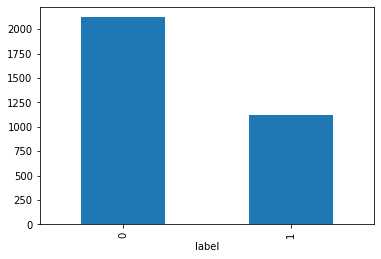

In [6]:
df.groupby(['label']).size().plot.bar()


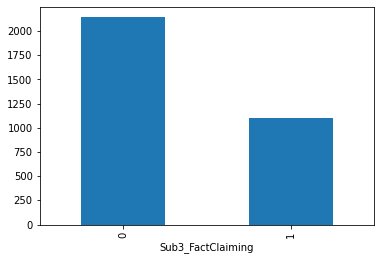

In [7]:
df.groupby(['Sub3_FactClaiming']).size().plot.bar()

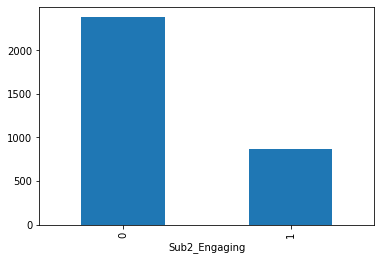

In [8]:
df.groupby(['Sub2_Engaging']).size().plot.bar()

# Hypothesis Evaluation Zero-Shot

In [9]:
def multi_hypo(config):
  res = []
  true_labels = []
  for sequence in tqdm(df['text'].values):
    num_labels = len(config['pos_label'])
    true_label = df[config['task']].loc[df['text'] == sequence].values[0]
    print(f'\n\nNEW sequence: {sequence}')
    pos_sequence_probability = 0
    neg_sequence_probability = 0
    for positive_label in config['pos_label']:
      result = classifier(sequence, positive_label, hypothesis_template=config['hypo'], multi_label=config['multi_class'])
      labels = result['labels']
      probs = result['scores']
      pos_probability = probs[0]
      print(labels,probs)

      pos_sequence_probability += pos_probability

    pos_sequence_probability = pos_sequence_probability / num_labels

    y_pred = 0
    if pos_sequence_probability > config['threshold']:
      y_pred = 1

    print(f'True label: {true_label}, Y_Pred: {y_pred}\n')
    res.append(y_pred)
    true_labels.append(true_label)

  
  return res
 

In [10]:
def eval_zero(predicted_labels,config): 
  true_labels = []
  for true_label in df[config['task']].values:
    true_labels.append(true_label)



  f1 = f1_score(true_labels,predicted_labels, average='macro')
  acc = accuracy_score(true_labels,predicted_labels)

  prec = precision_score(true_labels,predicted_labels)
  recall = recall_score(true_labels,predicted_labels)


  print(f'Accuracy: {acc}\n Precision: {prec}\n Recall: {recall}\n F1-Score: {f1}')

In [ ]:
config_toxic = {'pos_label': ['Beleidigung'],
                'neg_label': '',
                'hypo': 'Dieser Kommentar entspricht einer {}',
                'task': 'label',
                'threshold': 0.5,
                'multi_class': False}

config_engaging = {'pos_label': ['persönliche Erfahrung'],
                'neg_label': '',
                'hypo': 'Dieser Kommentar ist eine {}',
                'task': 'Sub2_Engaging',
                'threshold': 0.2,
                'multi_class': False}

config_fact = {'pos_label': ['externe'],
                'neg_label': '',
                'hypo': 'Dieser Kommentar ist eine {} Quelle',
                'task': 'Sub3_FactClaiming',
               'threshold': 0.1,
               'multi_class': False}

# choose config to be evaluated
config = config_toxic
predicted_labels = multi_hypo(config)
eval_zero(predicted_labels, config)

# Base evaluation of the Hypotheses


In [12]:
hypotheses_toxic = {"Zynismus": ["Dieser Kommentar enthält {}", 
                                    "Dieser Kommentar ist{}", 
                                    "Dieser Kommentar enspricht {}", 
                                    "In diesem Kommentar findet man eine {}"],
                    "Beleidigung":["Dieser Kommentar enthält eine {} gegen eine Person", 
                                    "Dieser Kommentar ist eine {} gegen eine Person", 
                                    "Dieser Kommentar enspricht einer {} gegen eine Person", 
                                    "In diesem Kommentar findet man eine {} gegen eine Person"],
                    "Sprache":["Dieser Kommentar enthält vulgäre {}",
                            "Dieser Kommentar ist vulgäre {}",
                            "Dieser Kommentar entspricht vulgärer{}",
                            "In diesem Kommentar findet man vulgäre {}"],
                    "Schreien":["Dieser Kommentar enthält {}",
                            "Dieser Kommentar ist {}",
                            "Dieser Kommentar entspricht {}",
                            "In diesem Kommentar findet man {}"],
                    "Diskreditierung":["Dieser Kommentar enthält {}",
                            "Dieser Kommentar ist {}",
                            "Dieser Kommentar entspricht {}",
                            "In diesem Kommentar findet man {}"],
                    "Diskriminierung":["Dieser Kommentar enthält {}",
                            "Dieser Kommentar ist {}",
                            "Dieser Kommentar entspricht {}",
                            "In diesem Kommentar findet man {}"],
                    "Lügenvorwurf":["Dieser Kommentar enthält einen{}",
                            "Dieser Kommentar ist ein {}",
                            "Dieser Kommentar entspricht einem {}",
                            "In diesem Kommentar findet man ein {}"]
                    }


hypotheses_engaging = {"Begründung": ["Dieser Kommentar enthält eine {}",
                                    "Dieser Kommentar entspricht einer {} ",
                                    "In diesem Kommentar findet man eine {}",
                                    "Dieser Kommentar ist eine {}"],
                       "externe Quelle": ["Dieser Kommentar entält eine {}",
                                        "Dieser Kommentar entspricht einer {}",
                                        "In diesem Kommentar findet man eine {}",
                                        "Dieser Kommentar ist eine {}"],
                       "persönliche Erfahrung":["Dieser Kommentar enthält eine {}",
                                    "Dieser Kommentar entspricht einer {} ",
                                    "In diesem Kommentar findet man eine {}",
                                    "Dieser Kommentar ist eine {}"],
                       "Lösungsvorschlag":["Dieser Kommentar enthält ein {}",
                                    "Dieser Kommentar entspricht einem {} ",
                                    "In diesem Kommentar findet man ein {}",
                                    "Dieser Kommentar ist ein {}"],
                       "Empathie":["Dieser Kommentar enthält {}",
                                    "Dieser Kommentar entspricht {} ",
                                    "In diesem Kommentar findet man{}",
                                    "Dieser Kommentar ist {}"],
                       "Respektbekundung":["Dieser Kommentar enthält eine {}",
                                    "Dieser Kommentar entspricht einer {} ",
                                    "In diesem Kommentar findet man eine {}",
                                    "Dieser Kommentar ist eine {}"],
                       "Anrede":["Dieser Kommentar enthält eine höfliche {}",
                                    "Dieser Kommentar entspricht einer höflichen {} ",
                                    "In diesem Kommentar findet man eine höfliche {}",
                                    "Dieser Kommentar ist eine höfliche {}"],
                       "Schlichtung":["Dieser Kommentar enthält eine {}",
                                    "Dieser Kommentar entspricht einer {} ",
                                    "In diesem Kommentar findet man eine {}",
                                    "Dieser Kommentar ist eine {}"]
                       }



hypotheses_fact = {"externe Quelle": ["Dieser Kommentar enthält eine {}",
                                    "Dieser Kommentar entspricht einer {} ",
                                    "In diesem Kommentar findet man eine {}",
                                    "Dieser Kommentar ist eine {}"],
                   "Wahrheitsanschpruch": ["Dieser Kommentar enthält einen {}",
                                    "Dieser Kommentar entspricht einem {} ",
                                    "In diesem Kommentar findet man einen {}",
                                    "Dieser Kommentar ist ein {}"],
                   "Tatsachenbehauptung": ["Dieser Kommentar enthält eine {}",
                                    "Dieser Kommentar entspricht einer {} ",
                                    "In diesem Kommentar findet man eine {}",
                                    "Dieser Kommentar ist eine {}"], }




In [ ]:
import numpy as np

best_hypotheses = []

outfile = open('outfile_fact_neg.txt', 'w', encoding='utf-8')
df = pd.read_csv('GermEval21_TrainData.csv')   
df = df.sample(frac=0.1, replace=True, random_state=1)
overview = {}
predicted_labels = []
for pos_label in hypotheses_toxic.keys():
  for hypothesis in hypotheses_toxic[pos_label]:
    #print(hypothesis,pos_label)
    thresholds = np.arange(0,1,0.1)
    best_threshold = 0
    highest_f1 = 0
    highest_acc = 0
    for threshold in thresholds:
      for sequence in df['text'].values:
        true_label = df['label'].loc[df['text'] == sequence].values[0]
        result = classifier(sequence, pos_label, hypothesis_template=hypothesis)
        if result['scores'][0] > threshold:
          predicted_labels.append(1)
        else:
          predicted_labels.append(0)


      true_labels = []
      for true_label in df['Sub2_Engaging'].values:
        true_labels.append(true_label)

      f1 = f1_score(true_labels,predicted_labels, average='macro')
      acc = accuracy_score(true_labels,predicted_labels)
      if f1 > highest_f1:
        highest_f1 = f1
        best_threshold = threshold
        overview[threshold] = [f1, acc]

      prec = precision_score(true_labels,predicted_labels)
      recall = recall_score(true_labels,predicted_labels)


      predicted_labels.clear()
      true_labels.clear()
    line = f'{hypothesis} + {pos_label} : Best threshold is: {best_threshold} with scores: {overview[best_threshold]} \n'
    outfile.write(line)

    print(f'Best threshold is: {best_threshold} with scores: {overview[best_threshold]} \n')
    print(f"hypothesis: {hypothesis}: {pos_label}")
      
    hypo = f'{hypothesis} {pos_label}'
    best_hypotheses.append(line)

    overview[hypo] = {'f1':f1, 'prec': prec, 'recall': recall, 'accuracy':acc} 



print(overview)
print(best_hypotheses)

    




# Hypothesis Engineering

## Toxic 

In [14]:
outfile = open('outfile_fact_neg.txt', 'w', encoding='utf-8')   
df = df.sample(frac=0.3, replace=True, random_state=1)
import numpy as np


In [15]:
hypothesis_toxic = {'pos':
                        {
                         "Beleidigung": ["Dieser Kommentar ist eine {}"],
                         "humoristisch veranlagt": ["Dieser Kommentar ist {}"],
                         "Zynismus": ["Dieser Kommentar ist {}"],
                         "Diskriminierung": ["In diesem Kommentar findet man {}"],
                         "gegen": ["Dieser Kommentar ist {} eine Gruppe gerichtet"]
                                    }
                        }

In [ ]:


thresholds = np.arange(0.2,1,0.2)
for threshold in thresholds:
  y_preds = []
  true_labels = []
  false_positives = []

  strategy_1_true = 0
  strategy_1_false = 0
  strategy_2_true = 0
  strategy_2_false = 0
  strategy_3_true = 0
  strategy_3_false = 0
  strategy_4_true = 0
  strategy_4_false = 0
  strategy_1_total = 0
  strategy_2_total = 0
  strategy_3_total = 0
  strategy_4_total = 0
  base_strategy_total = 0
  base_strategy_true = 0
  base_strategy_false = 0
  print(f'Threshold: {threshold}')
  for sequence in tqdm(df['text'].values):
    res = {}
    for pos_label in hypothesis_toxic['pos'].keys():
      for hypothesis in hypothesis_toxic['pos'][pos_label]:
        true_label = df['label'].loc[df['text'] == sequence].values[0]
        result = classifier(sequence, pos_label, hypothesis_template=hypothesis)
        positive_score = result['scores'][0]

      res[pos_label] = round(positive_score,2)
  

    res["true_label"] = true_label
  
    y_pred = 0


  # # Strategy Nr. 1
  # filter for SCREAMING sentences or !!! or ???
    tokens = sequence.split()
    count = 0
    special_tokens = ['@USER', '@MEDIUM', '@MODERATOR']
    if '!!!' in sequence or '???' in sequence:
      y_pred = 1
      strategy_1_total += 1
      y_preds.append(y_pred)
      true_labels.append(true_label)

      if y_pred == true_label:
        strategy_1_true += 1
      else:
        strategy_1_false += 1
      continue

    for token in tokens:

      token = token.rstrip(',.?!:"')
      token = token.lstrip('"')
    
      if token.isupper() and token.isalnum() and token not in special_tokens and len(token) > 3:
        count += 1
    if count > 1:
      y_pred = 1
      strategy_1_total += 1 
      y_preds.append(y_pred)
      true_labels.append(true_label)
    
      if y_pred == true_label:
        strategy_1_true += 1
      else:
        strategy_1_false += 1
  
      continue

  # Strategy Nr. 2 
    if res["Zynismus"] > 0.7:
      if res['humoristisch veranlagt'] > 0.3:
        strategy_2_total += 1
        y_pred = 0

        y_preds.append(y_pred)
        true_labels.append(true_label)

        if y_pred == true_label:
          strategy_2_true += 1
        else:
          strategy_2_false += 1
        continue
  

  # Strategy Nr. 3
    if res['Beleidigung'] > 0.5:
      if res['humoristisch veranlagt'] > 0.3:
        strategy_3_total += 1
        y_pred = 0

        if y_pred == true_label:
          strategy_3_true += 1
        else:
          strategy_3_false += 1
        y_preds.append(y_pred)
        true_labels.append(true_label)
        continue


  # Strategy Nr. 4 
    
    if res['Diskriminierung'] > 0.8:
      if res['gegen'] > 0.8:
        strategy_4_total += 1
        y_pred = 1

        if y_pred == true_label:
          strategy_4_true += 1
        else:
          strategy_4_false += 1
        y_preds.append(y_pred)
        true_labels.append(true_label)
        continue
      
    # BASE Strategy

    if res['Beleidigung'] > 0.5:
      y_pred = 1
    else:
      y_pred = 0
    base_strategy_total += 1

    if y_pred == true_label:
      base_strategy_true += 1
    else:
      base_strategy_false += 1

    y_preds.append(y_pred)
    true_labels.append(true_label)




  f1 = f1_score(true_labels,y_preds, average='macro')  
  acc = accuracy_score(true_labels,y_preds)

  prec = precision_score(true_labels,y_preds)
  recall = recall_score(true_labels,y_preds)
  print(f'Accuracy: {acc}\n Precision: {prec}\n Recall: {recall}\n F1-Score: {f1}')

  try:
    print(f'Total Strategy 1: {strategy_1_total}: True = {strategy_1_true}, False = {strategy_1_false}, Percentage true: {strategy_1_true / (strategy_1_total)} ')
    print(f'Total Strategy 2: {strategy_2_total}: True = {strategy_2_true}, False = {strategy_2_false}, Percentage true: {strategy_2_true / strategy_2_total }')
    print(f'Total Strategy 3: {strategy_3_total}: True = {strategy_3_true}, False = {strategy_3_false}, Percentage true: {strategy_3_true / strategy_3_total} ')
    print(f'Total Strategy 4: {strategy_4_total}: True = {strategy_4_true}, False = {strategy_4_false}, Percentage true: {strategy_4_true / strategy_4_total} ')
    print(f'Base Strategy: {base_strategy_total}: True = {base_strategy_true}, False = {base_strategy_false}, Percentage true: {base_strategy_true / base_strategy_total}')
  except(ZeroDivisionError):
    print('divzero')




## Engaging

In [ ]:
hypothesis_engaging = {'pos':
                        {
                         "Respektbekundung": ["Dieser Kommentar ist eine {}"],
                         "Ironie": ["Dieser Kommentar enthält {}"],
                         'externe Quelle': ["Dieser Kommentar ist eine {}"],
                         'Tatsachenbehauptung': ["Dieser Kommentar ist eine {}"],
                         'persönliche Erfahrung': ["Dieser Kommentar ist eine {}"]

                        
                                    }
                        }
thresholds = np.arange(0.2,1,0.2)
#thresholds = [0.2]


for threshold in thresholds:
  print('Threshold:', threshold)

  y_preds = []
  true_labels = []
  false_positives = []
  strategy_1_true = 0
  strategy_1_false = 0
  strategy_2_true = 0
  strategy_2_false = 0
  strategy_3_true = 0
  strategy_3_false = 0
  strategy_4_true = 0
  strategy_4_false = 0
  strategy_1_total = 0
  strategy_2_total = 0
  strategy_3_total = 0
  strategy_4_total = 0
  base_strategy_total = 0
  base_strategy_true = 0
  base_strategy_false = 0

  for sequence in tqdm(df['text'].values):
    res = {}
    for pos_label in hypothesis_engaging['pos'].keys():
      for hypothesis in hypothesis_engaging['pos'][pos_label]:
        true_label = df['Sub2_Engaging'].loc[df['text'] == sequence].values[0]
        result = classifier(sequence, pos_label, hypothesis_template=hypothesis)
        positive_score = result['scores'][0]

      res[pos_label] = round(positive_score,2)
  

    res["true_label"] = true_label
  


  # # Strategy Nr. 1
  # 
    
    tokens = sequence.split()
    signal_words = ['versteh', 'nachfühl', 'hinenversetz', 'empfind']
    for token in tokens:
      for signal_word in signal_words:
        if signal_word in token:
          y_pred = 1
          strategy_1_total += 1



          if y_pred == true_label:
            strategy_1_true += 1
          else:
            strategy_1_false += 1
          y_preds.append(y_pred)
          true_labels.append(true_label)
          continue
    
  # Höfliche Anreden 
  # Strategy Nr. 2  
    if sequence.startswith(('Lieber', 'Liebes', 'Liebe', "grüßen")):
      y_pred = 1
      strategy_2_total += 1

      if y_pred == true_label:
        strategy_2_true += 1
      else:
        strategy_2_false += 1
      y_preds.append(y_pred)
      true_labels.append(true_label)
      continue




# Strategy Nr. 3
    if res["Respektbekundung"] > 0.2:
      if res['Ironie'] > 0.6:
        strategy_3_total += 1
        y_pred = 0

        if y_pred == true_label:
          strategy_3_true += 1
        else:
          strategy_3_false += 1
        y_preds.append(y_pred)
        true_labels.append(true_label)
        continue


# Strategy Nr. 4
    if res['externe Quelle'] > 0.1:
      if res['Tatsachenbehauptung'] > 0.1:
        strategy_4_total += 1
        y_pred = 0

        if y_pred == true_label:
          strategy_4_true += 1
        else:
          strategy_4_false += 1
        y_preds.append(y_pred)
        true_labels.append(true_label)
        continue


    
    if res['persönliche Erfahrung'] > 0.2:
      y_pred = 1
    else:
      y_pred = 0

    
    base_strategy_total += 1

    if y_pred == true_label:
      base_strategy_true += 1
    else:
      base_strategy_false += 1

    y_preds.append(y_pred)
    true_labels.append(true_label)



  f1 = f1_score(true_labels,y_preds, average='macro')  
  acc = accuracy_score(true_labels,y_preds)

  prec = precision_score(true_labels,y_preds)
  recall = recall_score(true_labels,y_preds)
  print(f'Accuracy: {acc}\n Precision: {prec}\n Recall: {recall}\n F1-Score: {f1}')
  print(f'Total Strategy 2: {strategy_2_total}: True = {strategy_2_true}, False = {strategy_2_false}, Percentage true: {strategy_2_true / strategy_2_total }')
  print(f'Total Strategy 3: {strategy_3_total}: True = {strategy_3_true}, False = {strategy_3_false}, Percentage true: {strategy_3_true / strategy_3_total} ')
  print(f'Total Strategy 4: {strategy_4_total}: True = {strategy_4_true}, False = {strategy_4_false}, Percentage true: {strategy_4_true / strategy_4_total} ')
  print(f'Base Strategy: {base_strategy_total}: True = {base_strategy_true}, False = {base_strategy_false}, Percentage true: {base_strategy_true / base_strategy_total}')

Threshold: 0.2


  0%|          | 3/944 [00:21<1:52:01,  7.14s/it]


KeyboardInterrupt: ignored

## Fact-Claiming

In [ ]:
hypothesis_fact = {'pos':
                        {
                         'externe Quelle': ["Dieser Kommentar ist eine {}"],
                         'Tatsachenbehauptung': ["Dieser Kommentar ist eine {}"],
                         "Wahrheitsanspruch": ["Dieser Kommentar ist ein {}"]
                                    }
                        }
thresholds = np.arange(0.2,1,0.2)
thresholds = [0.2]

for threshold in thresholds:
  print('Threshold:', threshold)

  y_preds = []
  true_labels = []
  false_positives = []
  strategy_1_true = 0
  strategy_1_false = 0
  strategy_1_total = 0
  strategy_2_true = 0
  strategy_2_false = 0
  strategy_2_total = 0
  strategy_3_true = 0
  strategy_3_false = 0
  strategy_3_total = 0
  base_strategy_total= 0
  base_strategy_true = 0
  base_strategy_false = 0

  for sequence in tqdm(df['text'].values):
    res = {}
    for pos_label in hypothesis_fact['pos'].keys():
      for hypothesis in hypothesis_fact['pos'][pos_label]:
        true_label = df['Sub3_FactClaiming'].loc[df['text'] == sequence].values[0]
        result = classifier(sequence, pos_label, hypothesis_template=hypothesis)
        positive_score = result['scores'][0]

      res[pos_label] = round(positive_score,2)
  

    res["true_label"] = true_label


    link =  "http"
    if link in sequence:
      y_pred = 1
      strategy_3_total += 1
      if y_pred == true_label:
        strategy_3_true += 1
      else:
        strategy_3_false += 1
      y_preds.append(y_pred)
      true_labels.append(true_label)
      continue
      

    
     # Strategy Nr. 1
    if res['externe Quelle'] > 0.01:
      if res['Tatsachenbehauptung'] > 0.3:
        strategy_1_total += 1
        y_pred = 0

        if y_pred == true_label:
          strategy_1_true += 1
        else:
          strategy_1_false += 1
        y_preds.append(y_pred)
        true_labels.append(true_label)
        continue
    
    # Strategy 2
    if res['Tatsachenbehauptung'] > 0.2:
      if res['Wahrheitsanspruch'] > 0.2:
        strategy_2_total += 1
        y_pred = 0
        if y_pred == true_label:
          strategy_2_true += 1
        else:
          strategy_2_false += 1
        y_preds.append(y_pred)
        true_labels.append(true_label)
        continue



    # BASE Strategy

    if res['externe Quelle'] > 0.2:
      y_pred = 1
    else:
      y_pred = 0

    base_strategy_total += 1

    if y_pred == true_label:
      base_strategy_true += 1
    else:
      base_strategy_false += 1

    
    y_preds.append(y_pred)
    true_labels.append(true_label)





  f1 = f1_score(true_labels,y_preds, average='macro')  
  acc = accuracy_score(true_labels,y_preds)
  prec = precision_score(true_labels,y_preds)
  recall = recall_score(true_labels,y_preds)


  print(f'Accuracy: {acc}\n Precision: {prec}\n Recall: {recall}\n F1-Score: {f1}')
  print(f'Total Strategy 1: {strategy_1_total}: True = {strategy_1_true}, False = {strategy_1_false}, Percentage true: {strategy_1_true / (strategy_1_total)} ')
  print(f'Total Strategy 2: {strategy_2_total}: True = {strategy_2_true}, False = {strategy_2_false}, Percentage true: {strategy_2_true / (strategy_2_total)} ')
  print(f'Total Strategy 3: {strategy_3_total}: True = {strategy_3_true}, False = {strategy_3_false}, Percentage true: {strategy_3_true / (strategy_3_total)} ')
  print(f'Base Strategy: {base_strategy_total}: True = {base_strategy_true}, False = {base_strategy_false}, Percentage true: {base_strategy_true / base_strategy_total}')


Threshold: 0.2


  0%|          | 3/944 [00:03<13:13,  1.19it/s]/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1046: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
100%|██████████| 944/944 [01:23<00:00, 11.25it/s]

Accuracy: 0.6790254237288136
 Precision: 0.5617977528089888
 Recall: 0.1592356687898089
 F1-Score: 0.5220492768879865
Total Strategy 1: 44: True = 32, False = 12, Percentage true: 0.7272727272727273 
Total Strategy 2: 42: True = 33, False = 9, Percentage true: 0.7857142857142857 
Total Strategy 3: 22: True = 20, False = 2, Percentage true: 0.9090909090909091 
Base Strategy: 836: True = 556, False = 280, Percentage true: 0.6650717703349283
